<a href="https://colab.research.google.com/github/gregoryGuichard/first/blob/master/DNN_IA_Monithor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from fbprophet import Prophet
from datetime import timedelta
import datetime
import re
import numpy as np
%matplotlib inline
!pip install pandas-bokeh
pd.set_option('plotting.backend', 'pandas_bokeh')
import pandas_bokeh
from sklearn.model_selection import train_test_split
from math import ceil
import random
!pip install vacances-scolaires-france
from vacances_scolaires_france import SchoolHolidayDates

     |████████████████████████████████| 51kB 2.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def preprocess_data(data):
    

    # Get date of the day
    date_upto_keep_data = datetime.datetime.now().replace(
        hour=0, minute=0, second=0, microsecond=0)

    date_upto_keep_data = "2020-09-27 00:00:00"

    data["ds"] = pd.to_datetime(data[0], unit="s")
    data["value"] = data[1]
    data = data.sort_values(by="ds")
    del data[0]
    del data[1]
    data = data.dropna()

    data.index = data.ds

    data, value, vm, vstd = add_feature_and_scale(data)
    x_train, y_train,x_valid,y_valid, x_pred, y_pred = split_data(
        data, value)
    return x_train, y_train,x_valid,y_valid, x_pred, y_pred, vm, vstd

def add_feature_and_scale(data):
  

    data["min*hour"] = (data.ds.dt.minute * (data.ds.dt.hour + 1)) / (24*60)
    data["hour"] = data.ds.dt.hour / 23
    data["weekday"] = data.ds.dt.weekday / 6
    data["minutes"] = data.ds.dt.minute / 60
    data["dayofmonths"] = data.ds.dt.day / 31
    data["month"] = data.ds.dt.month / 12

    # Scale features of data
    for col in ["weekday", "month", "hour", "minutes", "dayofmonths", "min*hour"]:
        
        min = data[col].min()
        max = data[col].max()
        data[col+"scale1"] = (data[col] - data[col].mean()) / data[col].std()
        data[col+"scale2"] = (data[col] - min) / (max - min)
        
    data = pd.get_dummies(
        data, columns=["weekday", "month", "minutes", "dayofmonths", "hour"])

    # Scale target value
    vm = data.value.mean()
    vstd = data.value.std()
    value = (data.value - vm) / vstd
    #value = data.value
    del data["value"]
    del data["ds"]
    return data, value, vm, vstd



def split_data(data, value):
    last_ts = data.index[-1]

    jour = datetime.timedelta(days=1)
    fin_ts_train = last_ts - 5 * jour
    fin_ts_valid = last_ts - 2 * jour
    # Split data into train and prediction (usefull for smart scaling)
    x_train = data[(data.index > "2019-01-02 00:00:00")
                   & (data.index < fin_ts_train)]
    y_train = value[(value.index > "2019-01-02 00:00:00")
                    & (value.index < fin_ts_train)]


    x_valid = data[(data.index > fin_ts_train)
                   & (data.index < fin_ts_valid)]
    y_valid = value[(value.index > fin_ts_train)
                    & (value.index < fin_ts_valid)]

    # A enlever pour la PROD
    x_pred = data[data.index > fin_ts_valid]
    y_pred = value[value.index > fin_ts_valid]


    x_train, _, y_train, _ = train_test_split(
        x_train, y_train, test_size=0.00000001, random_state=42)



    return x_train, y_train,  x_valid, y_valid,x_pred, y_pred

In [9]:
data = pd.read_json('/content/drive/My Drive/attention net/auth_success_customerlogin100.json')
x_train, y_train, x_valid, y_valid, x_pred, y_pred, vm, vstd = preprocess_data(data)

## Pre-processing Data

## Data Science

In [10]:
import tensorflow as tf

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Average,Concatenate, Dropout
NB_IA = 19

In [12]:
models = []

for i in range(NB_IA):

  input = Input(shape=[x_train.shape[1]])
  temp = Dense(100, activation="relu")(input)
  temp = Dropout(0.25)(temp)
  temp = Dense(100, activation="relu")(temp)
  temp = Dropout(0.25)(temp)
  temp = Dense(100, activation="relu")(temp)
  temp = Dropout(0.25)(temp)
  temp = Dense(100, activation="relu")(temp)
  temp = Dropout(0.25)(temp)
  temp = Dense(100, activation="relu")(temp)
  temp = Dropout(0.25)(temp)
  output = Dense(1, activation="linear", name="dnn"+str(i))(temp)

  model = keras.Model(
      inputs=[input],
      outputs=output,
  )

  model.compile(
      optimizer=tf.keras.optimizers.RMSprop(),
      #optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= tf.keras.losses.MeanAbsoluteError()
  )

  models.append(model)

In [ ]:

for i in range(NB_IA):
  print(f"model n°{i}")
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0,
      patience=30,
      verbose=1,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )

  models[i].fit(x_train,
            y_train,
            epochs=5000,
            batch_size=64,
            callbacks=[early_stopping_monitor],
            validation_data=(x_valid, 
                            y_valid ),                                   
            validation_freq=1, 
            verbose=2)
  
#RMSprop 40 DNN lr 3e-3 15s par epoch 168 loss 0.44

model n°0
Epoch 1/5000
864/864 - 4s - loss: 0.3544 - val_loss: 0.3033
Epoch 2/5000
864/864 - 3s - loss: 0.2451 - val_loss: 0.2874
Epoch 3/5000
864/864 - 3s - loss: 0.2168 - val_loss: 0.2767
Epoch 4/5000
864/864 - 3s - loss: 0.2053 - val_loss: 0.2696
Epoch 5/5000
864/864 - 3s - loss: 0.1962 - val_loss: 0.3369
Epoch 6/5000
864/864 - 3s - loss: 0.1904 - val_loss: 0.2996
Epoch 7/5000
864/864 - 3s - loss: 0.1865 - val_loss: 0.2910
Epoch 8/5000
864/864 - 3s - loss: 0.1820 - val_loss: 0.2947
Epoch 9/5000
864/864 - 3s - loss: 0.1788 - val_loss: 0.3099
Epoch 10/5000
864/864 - 3s - loss: 0.1773 - val_loss: 0.2802
Epoch 11/5000
864/864 - 3s - loss: 0.1750 - val_loss: 0.3261
Epoch 12/5000
864/864 - 3s - loss: 0.1732 - val_loss: 0.2933
Epoch 13/5000
864/864 - 3s - loss: 0.1720 - val_loss: 0.2938
Epoch 14/5000
864/864 - 3s - loss: 0.1704 - val_loss: 0.3535
Epoch 15/5000
864/864 - 3s - loss: 0.1694 - val_loss: 0.3410
Epoch 16/5000
864/864 - 3s - loss: 0.1678 - val_loss: 0.2945
Epoch 17/5000
864/864 -

In [ ]:
from math import ceil
sum_seuil_bas = 0
sum_seuil_haut = 0
for i in range(ceil(x_train.shape[0]/50000)):
  predictions = []
  for j in range(NB_IA):
    prediction = models[j](x_train[i*50000:(i+1)*50000].values, training=False).numpy()
    predictions.append(prediction)
  df = pd.DataFrame(predictions[0]) *vstd + vm
  for ts in range(1, len(predictions)):
    df[ts] = predictions[ts] *vstd + vm

  df["mean"] = df.transpose().mean().transpose()
  df["std"] = df.transpose().std().transpose()
  df["y"] = np.array(y_train[i*50000:(i+1)*50000].values)*vstd + vm

  for j in range(1,150,1):
      df["IT1%"]  = (df["mean"] - j/10 * df["std"])
      df["IT99%"]  = (df["mean"] + j/10* df["std"])
      #stat["ds"] = y_train.index
      if df[ df["y"] > df["IT1%"]]["y"].count() / df["y"].count() > 0.99:
        print(f"Batch {i} seuil {j/10}")
        sum_seuil_bas += j/10
        break

  for j in range(1,150,1):
      df["IT1%"]  = (df["mean"] - j/10 * df["std"])
      df["IT99%"]  = (df["mean"] + j/10* df["std"])
      #stat["ds"] = y_train.index
      if df[ df["y"] < df["IT99%"]]["y"].count() / df["y"].count() > 0.99:
        print(f"Batch {i} seuil {j/10}")
        sum_seuil_haut += j/10
        break


seuil_bas = sum_seuil_bas / ceil(x_train.shape[0]/50000)
seuil_haut = sum_seuil_haut / ceil(x_train.shape[0]/50000)


In [ ]:
predictions = model.predict(x_pred)

predictions = []
for i in range(NB_IA):
    prediction = models[i].predict(x_pred)
    predictions.append(prediction)

pred_rs = []


predictions = np.array(predictions).reshape(NB_IA, np.array(predictions).shape[1])
for ts in range(len(predictions)-1):
  pred_rs.append(predictions[ts])


df = pd.DataFrame(pred_rs)
df = df*vstd + vm

stat = df.describe(percentiles=[0.01, 0.99, 0.95]).transpose()
stat["y"] = np.array(y_pred.values)*vstd + vm
stat["IT1%"]  = (stat["mean"] - seuil_bas* stat["std"])
stat["IT99%"]  = (stat["mean"] + seuil_haut* stat["std"])
stat["ds"] = y_pred.index

stat[ (stat["y"] > stat["IT1%"]) & (stat["y"] < stat["IT99%"])]["y"].count() / stat["y"].count()

In [ ]:
pred = stat
pred["Prédiction IT 99%"] = stat["IT99%"] 
pred["Prédiction IT 1%"] = stat["IT1%"]
pred["Prédiction"] = stat["mean"] 
pred["Nb de commandes"] = y_pred.values * vstd + vm


jour = "Journée du "+str(x_pred.index[0].day) +"-" +str(x_pred.index[0].month) + "-" + str(x_pred.index[0].year)
with open("/content/drive/My Drive/metrique/DNN40_mae-customstd-rms_5layers_BS64_100neuronnes_seuildiff_dropout/"+jour+".html" , "w") as f:
  html_plot = pred.plot_bokeh(x="ds", y=["Nb de commandes","Prédiction", "Prédiction IT 1%","Prédiction IT 99%", "99%", "1%" ], kind="line", xlabel="Date", ylabel="Nb de Commandes", title=jour,figsize=(1500, 700), return_html=True) 
  f.write(html_plot)

In [ ]:
date_de_test = "2020-07-29"
date_upto_test = datetime.datetime.strptime(date_de_test, '%Y-%m-%d')
jour = datetime.timedelta(days=1)

x_test_data = x_test[ (x_test.index > date_upto_test) & (x_test.index < date_upto_test + 1 * jour)].copy()
y_test_data = y_test[(x_test.index > date_upto_test) & (x_test.index < date_upto_test + 1 * jour)].copy()
predictions = model.predict(x_test_data)

pred_rs = []

predictions = np.array(predictions).reshape(41, np.array(predictions).shape[1])
for ts in range(len(predictions)-1):
  pred_rs.append(predictions[ts])


df = pd.DataFrame(pred_rs)
df = df*vstd + vm

stat = df.describe(percentiles=[0.05, 0.1, 0.95]).transpose()
stat["y"] = np.array(y_test_data.values)*vstd + vm
stat["IT5%"]  = (stat["mean"] - 2* stat["std"])
stat["IT95%"]  = (stat["mean"] + 2* stat["std"])
stat["IT1%"]  = (stat["mean"] - 3* stat["std"])
stat["IT99%"]  = (stat["mean"] + 3* stat["std"])
stat["ds"] = y_test_data.index

stat[stat["y"] < stat["5%"]]
stat[stat["y"] < stat["IT5%"]].ds

241    2020-07-29 04:03:00
245    2020-07-29 04:07:00
246    2020-07-29 04:08:00
467    2020-07-29 07:49:00
469    2020-07-29 07:51:00
               ...        
1433   2020-07-29 23:55:00
1434   2020-07-29 23:56:00
1435   2020-07-29 23:57:00
1436   2020-07-29 23:58:00
1437   2020-07-29 23:59:00
Name: ds, Length: 529, dtype: datetime64[ns]

In [ ]:
 stat[ (stat["y"] > stat["IT1%"]) & (stat["y"] < stat["IT99%"])]["y"].count() / stat["y"].count()

0.9993045897079277

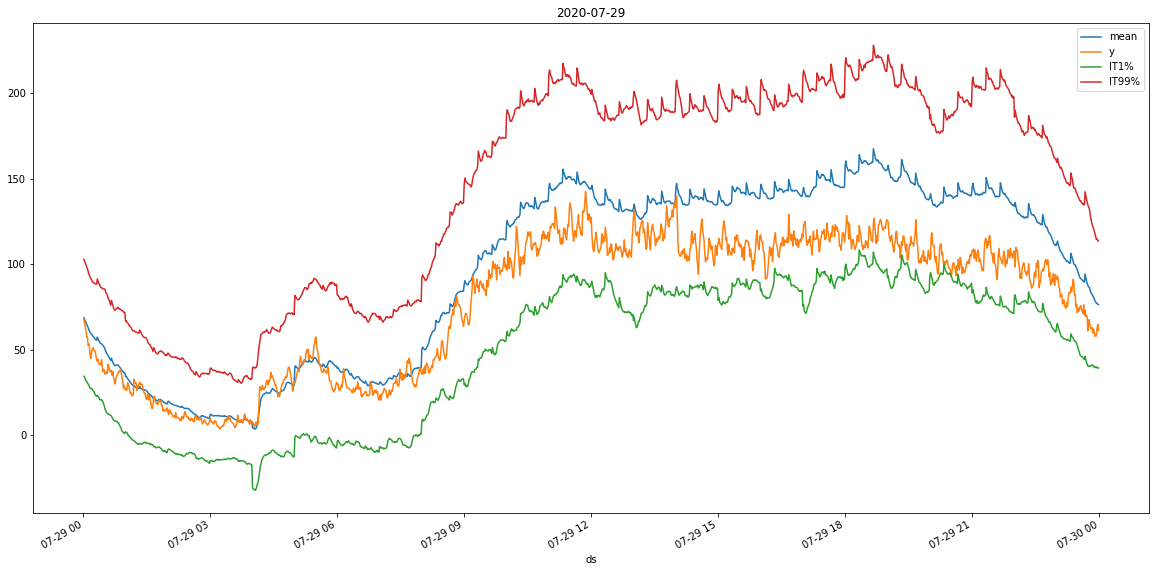

In [ ]:
stat.plot(y=["mean", "y", "IT1%", "IT99%"],x="ds", figsize=(20,10), title=date_de_test)